In [1]:
#https://aidanrussellcom.wordpress.com/2019/01/14/pystan-tutorial-1/

# TODO try larger dataset

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import get_data
np.random.seed(2024)
train, test = get_data(filepath="processed_data/full_data_secs.csv", size_train=1000, size_test=600)
train["propleft"] = 1 - train["prop"]
test["propleft"] = 1 - test["prop"]
train["propxcurr"] = train["prop"] * train["curr_pace"]
test["propxcurr"] = test["prop"] * test["curr_pace"]

train['male'] = train['gender'].apply(lambda x: 1 if x == 'M' else 0)
test['male'] = test['gender'].apply(lambda x: 1 if x == 'M' else 0)
train.to_csv("train.csv")
test.to_csv("test.csv")

#### Here: run from R file to populate /stan_results

rs_result1: finish ~ N(alpha + beta * feats, sigma); feats = [total_pace]

rs_result2: finish ~ N(alpha + beta * feats, sigma); feats = [total_pace, curr_pace]

rs_result3: finish ~ N(alpha + beta * feats, sigma); feats = [total_pace, prop]

rs_result4: finish ~ N(alpha + beta * feats, sigma); feats = [total_pace, curr_pace, prop]

rs_result5: finish ~ N(alpha + beta * feats, sigma * propleft); feats = [total_pace]

rs_result6: finish ~ N(alpha + beta * feats, sigma * propleft); feats = [total_pace, curr_pace]

rs_result7: finish ~ N(alpha + beta * feats, sigma * propleft); feats = [total_pace, prop]

rs_result8: finish ~ N(alpha + beta * feats, sigma * propleft); feats = [total_pace, curr_pace, prop]

9 adds "propxcurr" to 8, 91 adds ["propxcurr", "male"] to 8

In [170]:
marks = ["5K", "10K", "15K", "20K", "25K", "30K", "35K", "40K"]
rstan1 = pd.read_csv("stan_results/rs_result1.csv")
rstan2 = pd.read_csv("stan_results/rs_result2.csv")
rstan3 = pd.read_csv("stan_results/rs_result3.csv")
rstan4 = pd.read_csv("stan_results/rs_result4.csv")

rstan5 = pd.read_csv("stan_results/rs_result5.csv")
rstan6 = pd.read_csv("stan_results/rs_result6.csv")
rstan7 = pd.read_csv("stan_results/rs_result7.csv")
rstan8 = pd.read_csv("stan_results/rs_result8.csv")

rstan9 = pd.read_csv("stan_results/rs_result9.csv")
rstan91 = pd.read_csv("stan_results/rs_result91.csv")

# stan_results1 = pd.read_csv("stan_results/bayes1/ps_result.csv")
# stan_results2 = pd.read_csv("stan_results/bayes2/ps_result.csv")
# r_results1 = pd.read_csv("stan_results/bayes1/rs_result.csv")
# r_results2 = pd.read_csv("stan_results/bayes2/rs_result.csv")
rstan91.describe()

,Unnamed: 0,alpha,beta[1],beta[2],beta[3],beta[4],beta[5],sigma,lp__
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,2000.500000,-0.473313,0.912548,0.147457,0.532642,-0.069960,-0.003557,0.267801,14882.403878
std,1154.844867,0.020256,0.002373,0.006295,0.021913,0.006511,0.000922,0.002156,1.832238
min,1.000000,-0.546246,0.903763,0.125259,0.451379,-0.092287,-0.007007,0.258886,14872.678396
25%,1000.750000,-0.486722,0.910992,0.143085,0.517923,-0.074245,-0.004183,0.266373,14881.384817
50%,2000.500000,-0.472689,0.912500,0.147266,0.532107,-0.069884,-0.003558,0.267772,14882.685085
75%,3000.250000,-0.459375,0.914113,0.151573,0.547164,-0.065534,-0.002962,0.269215,14883.770169
max,4000.000000,-0.400272,0.920687,0.168117,0.605958,-0.044963,0.000378,0.275244,14885.727446


In [151]:
def full_predictions(test_data, stan_data, feats_lis, beta_lis, name="stan_pred"):
    test_new = test_data.copy()
    d1 = test_new[feats_lis]
    d2 = stan_data[beta_lis].T.copy()
    preds = np.random.normal(stan_data["alpha"] + d1.dot(d2.values), stan_data["sigma"])
    return preds

def get_predictions(test_data, stan_data, feats_lis, beta_lis, name="stan_pred"):
    test_new = test_data.copy()
    d1 = test_new[feats_lis]
    d2 = stan_data[beta_lis].T.copy()
    # preds = (stan_data["alpha"] + d1.dot(d2.values)).mean(axis=1)
    preds = np.random.normal(stan_data["alpha"] + d1.dot(d2.values), stan_data["sigma"]).mean(axis=1)
    test_new[name] = preds
    return test_new

def get_table(test_data, old="stan_pred", new="stan"):
    y_true = (42195 / 60) / test_data["finish"]
    preds = (42195 / 60) / test_data[old]
    extrap = (42195 / 60) / test_data["total_pace"]
    test_data[new] = preds - y_true
    test_data["extrap"] = extrap - y_true
    return test_data


def full_predictions_NEW(test_data, stan_data, feats_lis, beta_lis, name="stan_pred", propleft=False):
    test_new = test_data.copy()
    d1 = test_new[feats_lis]
    d2 = stan_data[beta_lis].T.copy()
    norm_mean = stan_data["alpha"] + d1.dot(d2.values)
    if propleft: 
        norm_std = np.outer(test_new["propleft"], stan_data["sigma"])
    else:
        norm_std = stan_data["sigma"]
    preds = np.random.normal(norm_mean, norm_std)
    return preds

def get_predictions_NEW(test_data, stan_data, feats_lis, beta_lis, name="stan_pred", propleft=False):
    test_new = test_data.copy()
    d1 = test_new[feats_lis]
    d2 = stan_data[beta_lis].T.copy()

    norm_mean = stan_data["alpha"] + d1.dot(d2.values)
    if propleft: 
        norm_std = np.outer(test_new["propleft"], stan_data["sigma"])
    else:
        norm_std = stan_data["sigma"]
    preds = np.random.normal(norm_mean, norm_std)
    
    preds = preds.mean(axis=1)
    test_new[name] = preds
    return test_new

In [173]:
# test_pred_r1 = get_predictions(test, rstan1, feats_lis=["total_pace"],  beta_lis=["beta[1]"])
# test_pred_r2 = get_predictions(test, rstan2, feats_lis=["total_pace", "curr_pace"],  beta_lis=["beta[1]", "beta[2]"])
# test_pred_r3 = get_predictions(test, rstan3, feats_lis=["total_pace", "prop"],  beta_lis=["beta[1]", "beta[2]"])
# test_pred_r4 = get_predictions(test, rstan4, feats_lis=["total_pace", "curr_pace", "prop"],  beta_lis=["beta[1]", "beta[2]", "beta[3]"])

test_pred_r1 = get_predictions_NEW(test, rstan1, feats_lis=["total_pace"],  beta_lis=["beta[1]"], propleft=False)
test_pred_r2 = get_predictions_NEW(test, rstan2, feats_lis=["total_pace", "curr_pace"],  beta_lis=["beta[1]", "beta[2]"], propleft=False)
test_pred_r3 = get_predictions_NEW(test, rstan3, feats_lis=["total_pace", "prop"],  beta_lis=["beta[1]", "beta[2]"], propleft=False)
test_pred_r4 = get_predictions_NEW(test, rstan4, feats_lis=["total_pace", "curr_pace", "prop"],  beta_lis=["beta[1]", "beta[2]", "beta[3]"], propleft=False)

test_pred_r5 = get_predictions_NEW(test, rstan1, feats_lis=["total_pace"],  beta_lis=["beta[1]"], propleft=True)
test_pred_r6 = get_predictions_NEW(test, rstan2, feats_lis=["total_pace", "curr_pace"],  beta_lis=["beta[1]", "beta[2]"], propleft=True)
test_pred_r7 = get_predictions_NEW(test, rstan3, feats_lis=["total_pace", "prop"],  beta_lis=["beta[1]", "beta[2]"], propleft=True)
test_pred_r8 = get_predictions_NEW(test, rstan4, feats_lis=["total_pace", "curr_pace", "prop"],  beta_lis=["beta[1]", "beta[2]", "beta[3]"], propleft=True)

test_pred_r9 = get_predictions_NEW(test, rstan9, feats_lis=["total_pace", "curr_pace", "prop", "propxcurr"],  beta_lis=["beta[1]", "beta[2]", "beta[3]", "beta[4]"], propleft=True)
test_pred_r91 = get_predictions_NEW(test, rstan91, feats_lis=["total_pace", "curr_pace", "prop", "propxcurr", "male"],  beta_lis=["beta[1]", "beta[2]", "beta[3]", "beta[4]", "beta[5]"], propleft=True)

# test_pred_t1 = get_predictions(test, stan_results1, feats_lis = ["total_pace", "prop"], beta_lis = ["beta.1", "beta.2"])
# test_pred_t2 = get_predictions(test, stan_results2, feats_lis = ["total_pace", "curr_pace", "prop"], beta_lis = ["beta.1", "beta.2", "beta.3"])
# test_pred_r1 = get_predictions_NEW(test, r_results1, feats_lis=["total_pace", "prop"],  beta_lis=["beta[1]", "beta[2]"])
# test_pred_r2 = get_predictions_NEW(test, r_results2, feats_lis=["total_pace", "curr_pace", "prop"],  beta_lis=["beta[1]", "beta[2]", "beta[3]"])


In [82]:
# s_data =pd.DataFrame([[4, 0.2], [3, 0.5]], columns=["total_pace", "prop"])
# full_predictions(s_data, stan_results1, feats_lis = ["total_pace", "prop"], beta_lis = ["beta.1", "beta.2"])
s_data =pd.DataFrame([[4, 0.2, .5], [3, 0.5, .5]], columns=["total_pace", "prop", "propleft"])
full_predictions_NEW(s_data, rstan7, feats_lis = ["total_pace", "prop"], beta_lis = ["beta[1]", "beta[2]"])

array([[4.2158579 , 3.69863451, 3.93410058, ..., 4.19946756, 3.81355069,
        4.25351952],
       [2.99841427, 2.78569322, 3.14675534, ..., 2.62921831, 3.1584205 ,
        2.88697776]])

In [174]:
table = get_table(test_pred_r1).copy()
# table["bayes1_sep"] = get_table(test_pred_r1)["stan"]
# table["bayes2_sep"] = get_table(test_pred_r2)["stan"]
# table["bayes1_stan"] = get_table(test_pred_r3)["stan"]
# table["bayes2_stan"] = get_table(test_pred_r4)["stan"]

# table["bayes1_sep"] = get_table(test_pred_r5)["stan"]
# table["bayes2_sep"] = get_table(test_pred_r6)["stan"]
# table["bayes1_stan"] = get_table(test_pred_r7)["stan"]
# table["bayes2_stan"] = get_table(test_pred_r8)["stan"]
table["rs1"] = get_table(test_pred_r1)["stan"]
table["rs2"] = get_table(test_pred_r2)["stan"]
table["rs3"] = get_table(test_pred_r3)["stan"]
table["rs4"] = get_table(test_pred_r4)["stan"]
table["rs5"] = get_table(test_pred_r5)["stan"]
table["rs6"] = get_table(test_pred_r6)["stan"]
table["rs7"] = get_table(test_pred_r7)["stan"]
table["rs8"] = get_table(test_pred_r8)["stan"]

table["rs9"] = get_table(test_pred_r9)["stan"]
table["rs91"] = get_table(test_pred_r91)["stan"]

table

,id,dist,curr_pace,total_pace,finish,age,gender,year,prop,propleft,...,rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs91
28,286805,5K,5.154639,5.154639,5.018435,31,M,2023,0.118497,0.881503,...,-0.125319,-0.094311,1.840010,2.782484,-0.014798,0.049784,1.835547,2.809684,0.261153,0.326866
71,286848,5K,4.677268,4.677268,4.851115,29,F,2023,0.118497,0.881503,...,9.600918,9.703871,12.418740,13.314227,9.708894,9.702664,12.397814,13.180750,11.597302,10.847549
85,286862,5K,4.897160,4.897160,4.806904,30,M,2023,0.118497,0.881503,...,1.150253,1.276077,3.491581,4.491564,1.315297,1.301285,3.632282,4.331138,2.504118,2.272793
120,286897,5K,5.117707,5.117707,4.720855,41,M,2023,0.118497,0.881503,...,-7.884238,-7.928158,-5.766581,-4.905965,-7.943304,-7.891686,-5.763357,-5.021560,-7.201470,-7.587190
125,286902,5K,4.616805,4.616805,4.707687,23,M,2023,0.118497,0.881503,...,7.345042,7.201011,10.119623,11.006219,7.404458,7.336342,10.120075,11.045606,9.147749,8.925215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208044,312625,40K,2.000000,1.992429,1.986675,56,F,2023,0.947980,0.052020,...,21.553062,21.215911,5.767845,-9.058835,20.897707,21.219300,6.291576,-8.551338,-3.837220,-4.437541
208069,312650,40K,1.803101,1.981768,1.978014,52,M,2023,0.947980,0.052020,...,21.559573,21.066348,6.953873,1.127398,21.542155,21.509068,6.688842,1.214099,-0.753914,-0.888980
208126,312707,40K,1.631321,1.960977,1.956008,27,F,2023,0.947980,0.052020,...,21.497962,21.558516,6.822188,9.601212,21.684894,21.536899,6.684994,9.276387,1.307160,0.423530
208138,312719,40K,1.728310,1.967439,1.951665,56,F,2023,0.947980,0.052020,...,19.919517,19.540168,5.473173,2.106751,19.558541,19.529585,4.603808,2.262817,-2.077809,-2.890180


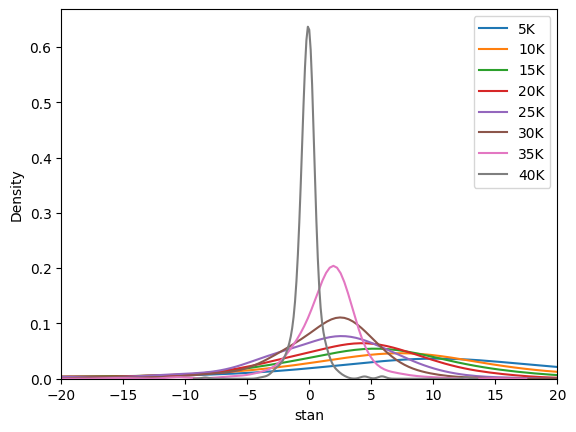

In [155]:
for mark in marks:
    sns.kdeplot(test_pred_r9[test_pred_r9["dist"] == mark]["stan"], label=mark)
plt.xlim(-20, 20)
plt.legend()

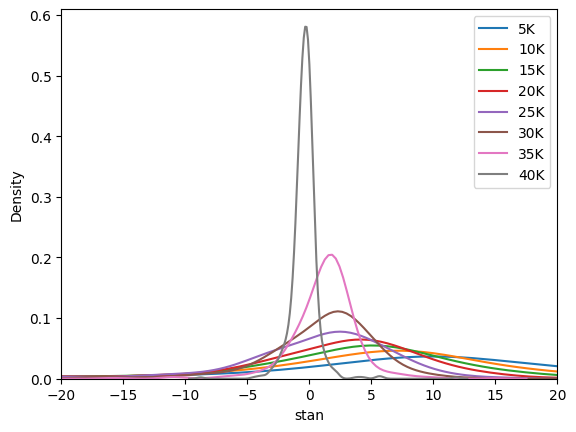

In [175]:
for mark in marks:
    sns.kdeplot(test_pred_r91[test_pred_r91["dist"] == mark]["stan"], label=mark)
plt.xlim(-20, 20)
plt.legend()

(10.481229123371778, 10.489206628758524, 9.936916515902777, 9.532400441657694)

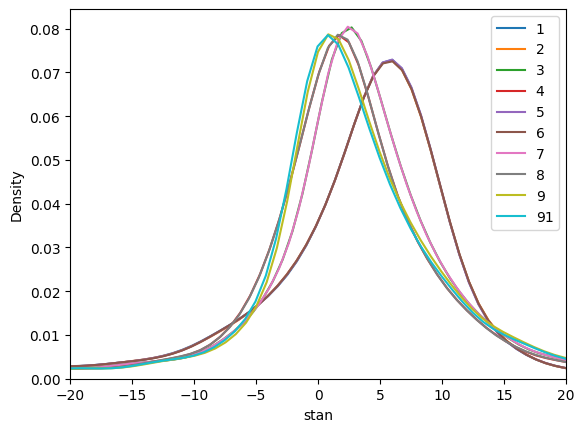

In [176]:
import seaborn as sns

sns.kdeplot(test_pred_r1["stan"], label="1")
sns.kdeplot(test_pred_r2["stan"], label="2")
sns.kdeplot(test_pred_r3["stan"], label="3")
sns.kdeplot(test_pred_r4["stan"], label="4")
sns.kdeplot(test_pred_r5["stan"], label="5")
sns.kdeplot(test_pred_r6["stan"], label="6")
sns.kdeplot(test_pred_r7["stan"], label="7")
sns.kdeplot(test_pred_r8["stan"], label="8")
sns.kdeplot(test_pred_r9["stan"], label="9")
sns.kdeplot(test_pred_r91["stan"], label="91")
plt.xlim(-20, 20)
plt.legend()
((test_pred_r1["stan"] **2).mean()) ** 0.5, ((test_pred_r2["stan"] **2).mean()) ** 0.5, ((test_pred_r3["stan"] **2).mean()) ** 0.5 , ((test_pred_r4["stan"] **2).mean()) ** 0.5

         extrap        rs3        rs4        rs9       rs91
dist                                                       
5K    17.606298  16.724016  16.935826  18.419978  18.249443
10K   16.679752  13.334388  12.829777  13.800430  13.683134
15K   15.372401  11.326266  10.556069  11.194532  11.132996
20K   12.992163   9.260070   8.369207   8.951016   8.896655
25K   10.865553   7.556627   6.384003   7.076396   7.046626
30K    7.749922   5.902858   4.626275   5.335830   5.272017
35K    4.362576   4.444331   3.885678   3.477913   3.368356
40K    1.197432   2.590029   4.096003   1.100832   1.161301


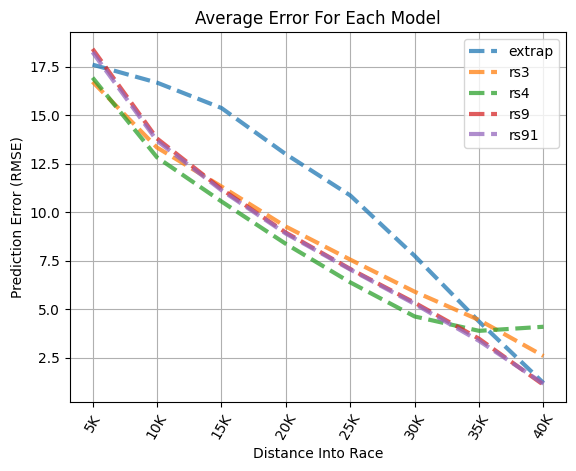

In [177]:
# labels = ["extrap", "stan", "stan_sep"]#, "bayes2", "quant1", "quant2"]

labels = ["extrap", "rs1", "rs2", "rs3", "rs4", "rs5", "rs6", "rs7", "rs8"]
labels = ["extrap", "rs3", "rs4", "rs9", "rs91"]
colors = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8"]
colors = ["C0", "C1", "C2", "C3", "C4"]
styles = '--'
mks = ["5K", "10K", "15K", "20K", "25K", "30K", "35K", "40K"]
table_group = table.groupby(["dist"])[labels].apply(lambda x: (x ** 2).mean() ** 0.5).loc[mks]
print(table_group)
table_group.plot(label=table_group.columns,  style=styles, linewidth=3, grid=True, alpha=0.75, color=colors)

plt.xlabel("Distance Into Race")
plt.ylabel("Prediction Error (RMSE)")
plt.xticks(rotation=60)
plt.title("Average Error For Each Model")
plt.grid(True)
plt.legend()
# plt.savefig("analysis/all_errors_new1.png", bbox_inches="tight")

In [85]:
full_pred1 =  (42195 / 60) / full_predictions_NEW(test, rstan1, feats_lis = ["total_pace"], beta_lis = ["beta[1]"], propleft=False)
full_pred2 =  (42195 / 60) / full_predictions_NEW(test, rstan2, feats_lis = ["total_pace", "curr_pace"], beta_lis = ["beta[1]", "beta[2]"], propleft=False)
full_pred3 =  (42195 / 60) / full_predictions_NEW(test, rstan3, feats_lis = ["total_pace", "prop"], beta_lis = ["beta[1]", "beta[2]"], propleft=False)
full_pred4 =  (42195 / 60) / full_predictions_NEW(test, rstan4, feats_lis = ["total_pace", "curr_pace", "prop"], beta_lis = ["beta[1]", "beta[2]", "beta[3]"], propleft=False)
full_pred5 =  (42195 / 60) / full_predictions_NEW(test, rstan5, feats_lis = ["total_pace"], beta_lis = ["beta[1]"], propleft=True)
full_pred6 =  (42195 / 60) / full_predictions_NEW(test, rstan6, feats_lis = ["total_pace", "curr_pace"], beta_lis = ["beta[1]", "beta[2]"], propleft=True)
full_pred7 =  (42195 / 60) / full_predictions_NEW(test, rstan7, feats_lis = ["total_pace", "prop"], beta_lis = ["beta[1]", "beta[2]"], propleft=True)
full_pred8 =  (42195 / 60) / full_predictions_NEW(test, rstan8, feats_lis = ["total_pace", "curr_pace", "prop"], beta_lis = ["beta[1]", "beta[2]", "beta[3]"], propleft=True)

# full_preds1 =  (42195 / 60) / full_predictions(test, stan_results1, feats_lis = ["total_pace", "prop"], beta_lis = ["beta.1", "beta.2"])
# full_preds2 =  (42195 / 60) / full_predictions(test, stan_results2, feats_lis = ["total_pace", "curr_pace", "prop"], beta_lis = ["beta.1", "beta.2", "beta.3"])
# full_sep1 =  (42195 / 60) / full_predictions_NEW(test, r_results1, feats_lis = ["total_pace", "prop"], beta_lis = ["beta[1]", "beta[2]"])
# full_sep2 =  (42195 / 60) / full_predictions_NEW(test, r_results2, feats_lis = ["total_pace", "curr_pace", "prop"], beta_lis = ["beta[1]", "beta[2]", "beta[3]"])

full_pred1.shape, full_pred2.shape, full_pred3.shape, full_pred4.shape, full_pred5.shape, full_pred6.shape, full_pred7.shape, full_pred8.shape

((4800, 4000),
 (4800, 4000),
 (4800, 4000),
 (4800, 4000),
 (4800, 4000),
 (4800, 4000),
 (4800, 4000),
 (4800, 4000))

In [161]:
full_pred9 =  (42195 / 60) / full_predictions_NEW(test, rstan9, feats_lis=["total_pace", "curr_pace", "prop", "propxcurr"],  beta_lis=["beta[1]", "beta[2]", "beta[3]", "beta[4]"], propleft=True)

In [162]:
full_pred9

array([[139.7928832 , 130.08864519, 139.74474675, ..., 138.20335907,
        143.56937735, 146.52224584],
       [173.13303224, 159.37876131, 151.92030517, ..., 155.91573743,
        172.41579788, 162.61705967],
       [147.04458105, 141.31054676, 137.71553007, ..., 152.07617192,
        136.36822753, 157.42725959],
       ...,
       [355.99147233, 358.63323968, 359.47284653, ..., 359.64519572,
        362.98647412, 357.37295176],
       [355.68157395, 355.66081073, 359.28938714, ..., 360.72282332,
        358.95322054, 358.53126578],
       [380.68633758, 376.83172297, 378.78833115, ..., 377.24483157,
        383.19520796, 381.18738957]])

In [86]:
# (42195/60) / test["finish"]
full_pred1.max(axis=1) - full_pred1.min(axis=1)#.shape
full_pred5.max(axis=1) - full_pred5.min(axis=1)#.shape

array([84.70988287, 83.52932978, 72.43383731, ..., 26.81915442,
       26.80058895, 28.50696424])

In [163]:
def add_intervals_to_test(data_tbl, preds1, preds2, preds3, preds4):#, q1, q2):
    data = data_tbl.copy()
    for conf, lower, upper in [(50, 25, 75), (80, 10, 90), (95, 2.5, 97.5)]:
        test_true = (42195 / 60) / data["finish"]
        b11, b12 = np.percentile(preds1, [lower, upper], axis=1)
        data[f"stan1-lower{conf}"] = b11
        data[f"stan1-upper{conf}"] = b12
        data[f"stan1-size{conf}"] = b12 - b11
        data[f"stan1-in{conf}"] = (test_true < b12) & (test_true > b11)

        b21, b22 = np.percentile(preds2, [lower, upper], axis=1)
        data[f"stan2-lower{conf}"] = b21
        data[f"stan2-upper{conf}"] = b22
        data[f"stan2-size{conf}"] = b22 - b21
        data[f"stan2-in{conf}"] = (test_true < b22) & (test_true > b21)

        b31, b32 = np.percentile(preds3, [lower, upper], axis=1)
        data[f"stan3-lower{conf}"] = b31
        data[f"stan3-upper{conf}"] = b32
        data[f"stan3-size{conf}"] = b32 - b31
        data[f"stan3-in{conf}"] = (test_true < b32) & (test_true > b31)

        b41, b42 = np.percentile(preds4, [lower, upper], axis=1)
        data[f"stan4-lower{conf}"] = b41
        data[f"stan4-upper{conf}"] = b42
        data[f"stan4-size{conf}"] = b42 - b41
        data[f"stan4-in{conf}"] = (test_true < b42) & (test_true > b41)

    return data

In [164]:
# table2 = add_intervals_to_test(table, full_pred1, full_pred2, full_pred3, full_pred4)
table2 = add_intervals_to_test(table, full_pred9, full_pred6, full_pred7, full_pred8)
# table2 = add_intervals_to_test(table, full_pred5, full_pred6)
# table2 = add_intervals_to_test(table, full_pred7, full_pred8)
# table2 = add_intervals_to_test(table, full_sep1, full_sep2)
table2

,id,dist,curr_pace,total_pace,finish,age,gender,year,prop,propleft,...,stan2-size95,stan2-in95,stan3-lower95,stan3-upper95,stan3-size95,stan3-in95,stan4-lower95,stan4-upper95,stan4-size95,stan4-in95
28,286805,5K,5.154639,5.154639,5.018435,31,M,2023,0.118497,0.881503,...,32.676921,True,129.741153,160.911808,31.170655,True,131.023221,158.090576,27.067355,True
71,286848,5K,4.677268,4.677268,4.851115,29,F,2023,0.118497,0.881503,...,40.240082,True,142.110616,179.522548,37.411931,True,143.378353,177.963611,34.585258,True
85,286862,5K,4.897160,4.897160,4.806904,30,M,2023,0.118497,0.881503,...,37.520593,True,136.052612,170.947324,34.894712,True,137.390412,168.231094,30.840682,True
120,286897,5K,5.117707,5.117707,4.720855,41,M,2023,0.118497,0.881503,...,33.884888,True,130.677141,161.308529,30.631388,True,131.668424,160.542680,28.874255,True
125,286902,5K,4.616805,4.616805,4.707687,23,M,2023,0.118497,0.881503,...,40.813079,True,143.739105,182.082922,38.343817,True,145.727198,179.362845,33.635648,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208044,312625,40K,2.000000,1.992429,1.986675,56,F,2023,0.947980,0.052020,...,13.053359,True,348.977639,359.790299,10.812661,True,345.925572,355.469649,9.544076,True
208069,312650,40K,1.803101,1.981768,1.978014,52,M,2023,0.947980,0.052020,...,13.302019,True,350.805944,361.722924,10.916980,True,350.361910,360.288883,9.926973,True
208126,312707,40K,1.631321,1.960977,1.956008,27,F,2023,0.947980,0.052020,...,13.630579,True,354.353302,365.607237,11.253935,True,356.294708,366.558771,10.264063,True
208138,312719,40K,1.728310,1.967439,1.951665,56,F,2023,0.947980,0.052020,...,13.465079,True,353.382605,364.577208,11.194603,True,353.948102,364.018597,10.070495,True


In [15]:
from collections import Counter
Counter(table2["bayes1-in50"])

Counter({True: 3533, False: 2867})

<Figure size 4000x4000 with 0 Axes>

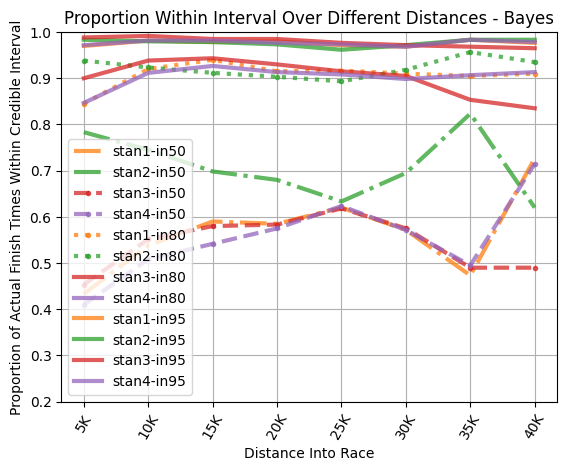

In [165]:
colors = ['C1', 'C2', 'C3', 'C4'] * 3
tables = []
for conf, style in [(50, "-."), (80, "--."), (95, ":.")]:
    sublabels = [f"stan1-in{conf}", f"stan2-in{conf}", f"stan3-in{conf}", f"stan4-in{conf}"]
    table3 = table2.groupby(["dist"])[sublabels].apply(lambda x: np.sum(x) / len(x)).loc[mks]
    tables.append(table3)

plt.figure(figsize=(40, 40))
big_table = pd.concat(tables, axis=1)
big_table.plot(label=big_table.columns,  style=["-."] * 2 + ["--."] * 2 + [":."] * 2 , linewidth=3, grid=True, alpha=0.75, color=colors)
# plt.ylim(0.2, 1) 
plt.legend(loc="lower center")

plt.xlabel("Distance Into Race")
plt.ylabel("Proportion of Actual Finish Times Within Credible Interval")
plt.xticks(rotation=60)
plt.ylim(0.2, 1)
plt.title("Proportion Within Interval Over Different Distances - Bayes")
plt.grid(True)
plt.legend()
# plt.savefig("analysis/interval_check_bayes.png", bbox_inches="tight")

<Figure size 3000x2000 with 0 Axes>

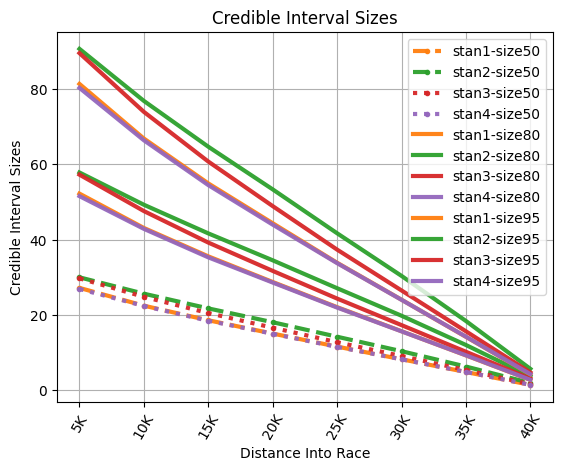

In [166]:
colors = ['C1', 'C2', 'C3', 'C4'] * 3
tables = []
for conf, style in [(50, "-."), (80, "--."), (95, ":.")]:
    sublabels = [f"stan1-size{conf}", f"stan2-size{conf}", f"stan3-size{conf}", f"stan4-size{conf}"]
    table3 = table2.groupby(["dist"])[sublabels].apply(lambda x: (x ** 2).mean() ** 0.5).loc[mks]
    tables.append(table3)

plt.figure(figsize=(30, 20))
big_table = pd.concat(tables, axis=1)
big_table.plot(label=big_table.columns,  style= ["--."] * 2 + [":."] * 2 , linewidth=3, grid=True, alpha=0.95, color=colors)

plt.xlabel("Distance Into Race")
plt.ylabel("Credible Interval Sizes")
plt.xticks(rotation=60)
plt.title("Credible Interval Sizes")
plt.grid(True)
# plt.savefig("analysis/interval_sizes_bayes.png", bbox_inches="tight")
